## This nb borrowed lines from fastai, OpenAI & ChatGPT

In [1]:
from miniai.imports import *
import torch
from transformers import CLIPProcessor, CLIPModel
import torchvision.transforms.functional as TF,torch.nn.functional as F

In [2]:
import fastcore.all as fc
from miniai.datasets import *
from miniai.training import *

from datasets import load_dataset,load_dataset_builder
from diffusers import AutoencoderKL

In [3]:
from huggingface_hub import hf_hub_download
import json 

In [4]:
class SomeException(BaseException):
    pass
    
try:
    if torch.cuda.is_available():
        print('# of GPUs available = ', torch.cuda.device_count())
    else:
        raise SomeException
except SomeException:
    print("ERROR: GPU is missing")

# of GPUs available =  1


### Loading Tiny-Imagenet

In [5]:
xl,yl = 'image','label'
name = "zh-plus/tiny-imagenet"
dsd = load_dataset(name)

In [6]:
bs = 32

In [7]:
class TinyHFDS:
    # this is specific for Hugging Face's dsd which can be very slow to index
    def __init__(self, hg_ds):
        self.ds = hg_ds
        # the 2 lines below must be done here because the execution of "ds['train']['image']" takes 18seconds
        # once it has executed, indexing it is very fast (5 milliseconds)
        self.image = hg_ds['image']
        self.label = hg_ds['label']
    def __len__(self): return self.ds.num_rows
    def __getitem__(self, i): return TF.to_tensor(self.image[i]), self.label[i]

In [8]:
tds = TinyHFDS(dsd['train'])

In [9]:
vds = TinyHFDS(dsd['valid'])

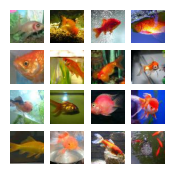

In [10]:
dl = DataLoader(tds, batch_size=bs, num_workers=fc.defaults.cpus)
xb,yb = next(iter(dl))
show_images(xb[:16], imsize=0.5)

In [11]:
vae = AutoencoderKL.from_pretrained("stabilityai/sd-vae-ft-ema").cuda().requires_grad_(False)

In [12]:
%%time
xe = vae.encode(xb.cuda())

CPU times: user 623 ms, sys: 325 ms, total: 948 ms
Wall time: 3 s


In [13]:
xs = xe.latent_dist.mean[:16]
xs.shape

torch.Size([16, 4, 8, 8])

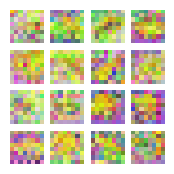

In [14]:
show_images(((xs[:16,:3])/4).sigmoid(), imsize=0.5)

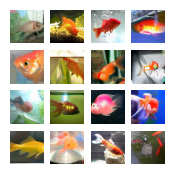

In [15]:
xd = to_cpu(vae.decode(xs))
show_images(xd['sample'].clamp(0,1), imsize=0.5)

In [16]:
class TfmDS:
    def __init__(self, ds, tfmx=fc.noop, tfmy=fc.noop): self.ds,self.tfmx,self.tfmy = ds,tfmx,tfmy
    def __len__(self): return len(self.ds)
    def __getitem__(self, i):
        x,y = self.ds[i]
        return self.tfmx(x),self.tfmy(y)

### TODO: Add normalisation to datasets, see Jeremy's nb_24

In [33]:
def tfmx(x):
    try:
        if len(x.shape) == 3 and x.shape[0] == 3:
            pass
        else:
            x = torch.ones([3,1,1]) * x
        x = vae.encode(x.cuda()[None,:,:,:]).latent_dist.mean
        x = x.squeeze()
    except SomeException:
        print("ERROR: x doesn't have 3 channels")
    return x

In [34]:
def tfmy(y): 
    return y

In [35]:
tfm_tds = TfmDS(tds, tfmx, tfmy)
tfm_vds = TfmDS(vds, tfmx, tfmy)

In [36]:
dls = DataLoaders(*get_dls(tfm_tds, tfm_vds, bs=bs, num_workers=0))

In [ ]:
dt = dls.train

In [43]:
%%time
xb,yb = next(iter(dt))

CPU times: user 963 ms, sys: 59.3 ms, total: 1.02 s
Wall time: 225 ms


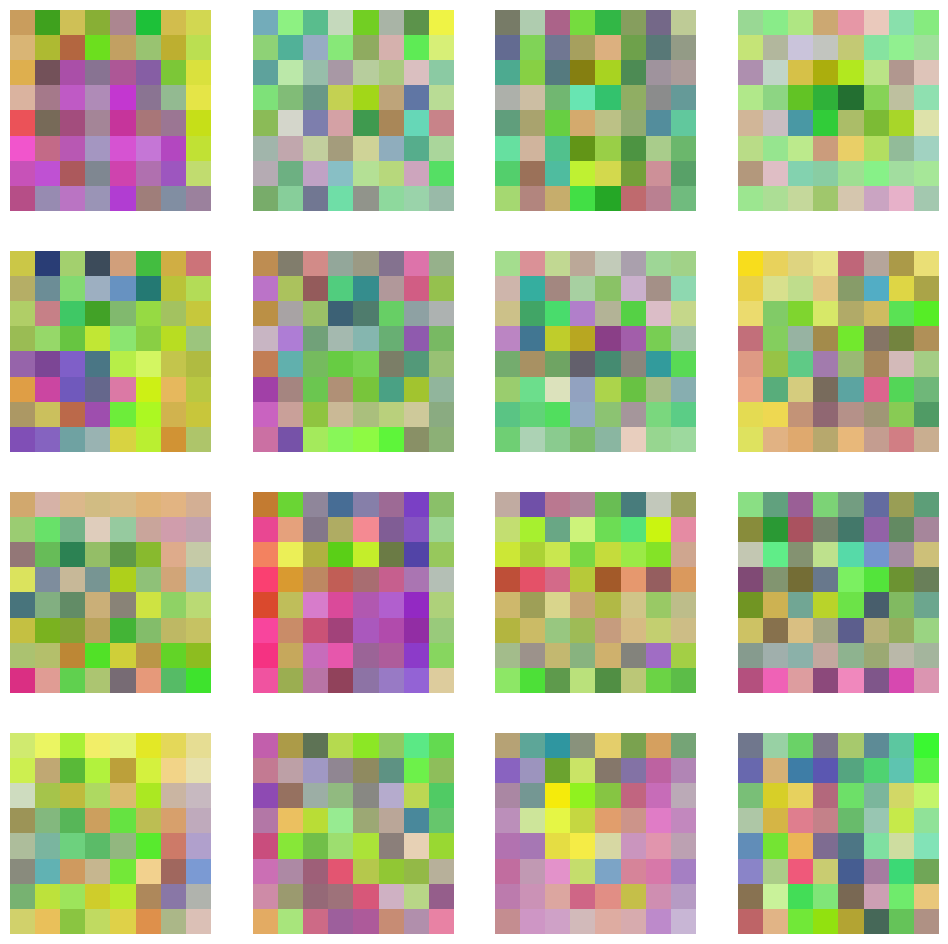

In [40]:
show_images(((xb[:16,:3])/4).sigmoid())

In [41]:
yb

tensor([ 55,  53, 186, 106, 187,  27,   9,  69,  93,  55,  81, 123,  31,  73,
        193,  55, 191,  87,   3,  51, 171, 145, 147, 163,  83, 167,  20, 135,
         61, 102,  23, 109])

In [17]:
xb,yb = next(iter(dt))

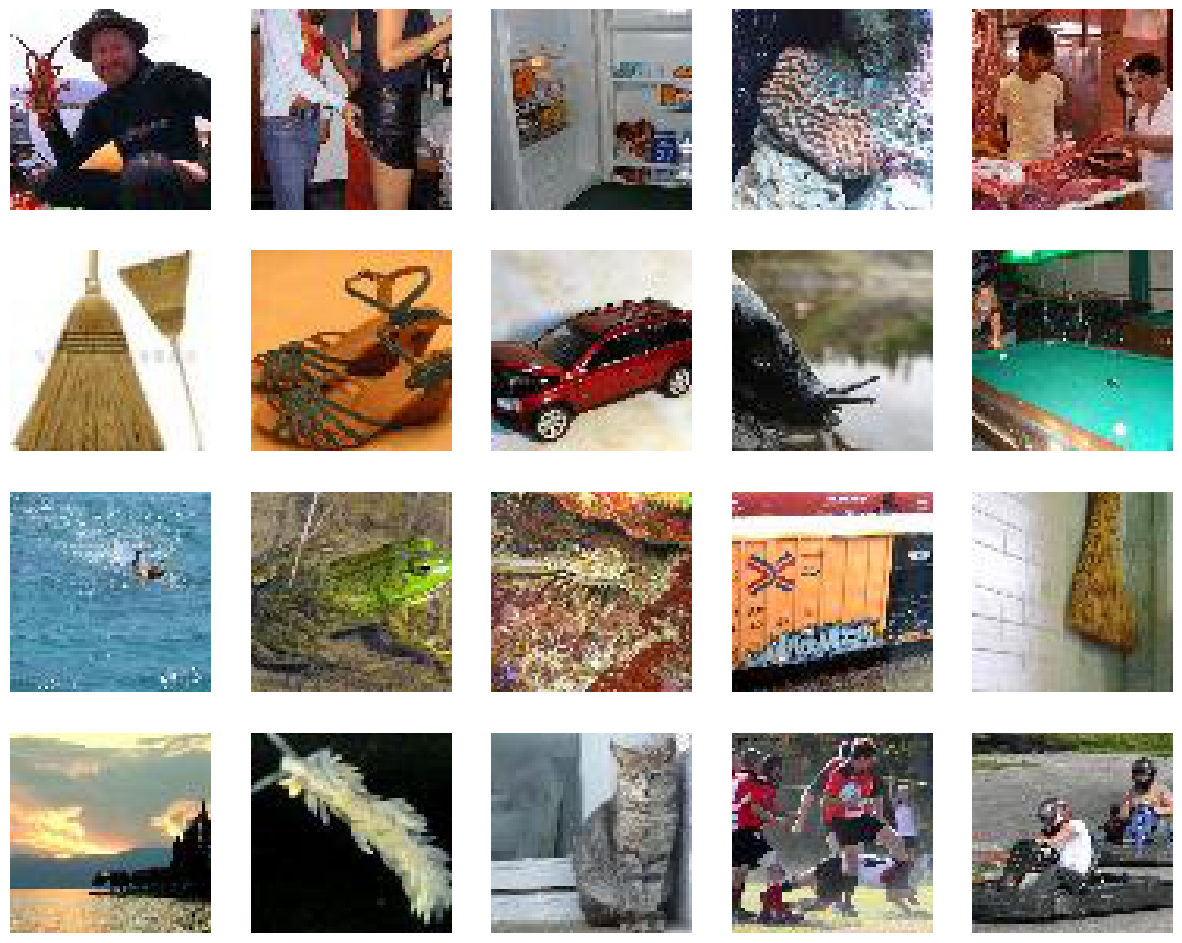

In [18]:
show_images(xb[0:20])

In [ ]:
#| export
class BatchTransformCB(Callback):
    def __init__(self, tfm, on_train=True, on_val=True): fc.store_attr()

    def before_batch(self, learn):
        if (self.on_train and learn.training) or (self.on_val and not learn.training):
            learn.batch = self.tfm(learn.batch)

In [ ]:
def _norm(b): return (b[0]-xmean)/xstd,b[1]
norm = BatchTransformCB(_norm)